<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Downtown_LA_Traffic_Prediction_I10_W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras

In [19]:
controller_data = pd.read_csv('Combined flows.csv')
controller_data.dropna(how='all', inplace=True)

In [20]:
controller_data["5 Minutes"] = pd.to_datetime(controller_data["5 Minutes"])
controller_data.set_index("5 Minutes", inplace=True)

# Keep only the relevant column
time_flow = controller_data[['THIRD Flow (Veh/5 Minutes)', 'INDIANA Flow (Veh/5 Minutes)', 'LORENA Flow (Veh/5 Minutes)', 'MARRIETTA Flow (Veh/5 Minutes)', 'SOTO Flow (Veh/5 Minutes)', 'SANATA FE / MATEO Flow (Veh/5 Minutes)', 'CENTRAL AVE Flow (Veh/5 Minutes)', 'FM 110 NB Flow (Veh/5 Minutes)', 'HOOVER 1 Flow (Veh/5 Minutes)', 'VERMONT 2 Flow (Veh/5 Minutes)', 'VERMONT 1 Flow (Veh/5 Minutes)', 'BUDLONG Flow (Veh/5 Minutes)', 'NORMANDIE 1 Flow (Veh/5 Minutes)']]

print(time_flow)

                     THIRD Flow (Veh/5 Minutes)  INDIANA Flow (Veh/5 Minutes)  \
5 Minutes                                                                       
2024-04-01 00:00:00                         148                           110   
2024-04-01 00:05:00                         162                           124   
2024-04-01 00:10:00                         148                           114   
2024-04-01 00:15:00                         146                           107   
2024-04-01 00:20:00                         206                           154   
...                                         ...                           ...   
2024-04-07 23:35:00                         182                           147   
2024-04-07 23:40:00                         195                           159   
2024-04-07 23:45:00                         159                           126   
2024-04-07 23:50:00                         172                           129   
2024-04-07 23:55:00         

In [7]:
print(time_flow.shape)

(2016, 13)


In [8]:
# Normalise
scaler = MinMaxScaler()
flow_normalised = scaler.fit_transform(time_flow)

In [9]:
# Train and validation split
train = len(flow_normalised)*0.8
X_train, X_val, = flow_normalised[:int(train), :], flow_normalised[int(train):, :]

In [10]:
print(X_train.shape)

(1612, 13)


In [11]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_dataset(X_train, look_back)
X_val, y_val = create_dataset(X_val, look_back)


# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

In [12]:
print(X_train.shape)

(1600, 12, 13)


In [13]:
from keras import layers

input_layer = keras.layers.Input(shape=(look_back, 13))
encoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.RepeatVector(look_back)(encoded)
decoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = keras.layers.TimeDistributed(layers.Dense(1, activation='linear'))(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 12, 13)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 12, 64)              │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 12, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 12, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 12, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,281 (223.75 KB)

 Trainable params: 57,281 (223.75 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_val, X_val])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.1574 - val_loss: 0.0234
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0247 - val_loss: 0.0144
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0190 - val_loss: 0.0134
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0181 - val_loss: 0.0130
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0182 - val_loss: 0.0131
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0175 - val_loss: 0.0128
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0178 - val_loss: 0.0127
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0173 - val_loss: 0.0125
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0179 - val_loss: 0.0126
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0173 - val_loss: 0.0126
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0176 - val_loss: 0.0127
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

In [15]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [16]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(1, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_val, y_val))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3444 - val_loss: 0.1409
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0740 - val_loss: 0.0164
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0243 - val_loss: 0.0150
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - val_loss: 0.0142
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 - val_loss: 0.0135
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 - val_loss: 0.0131
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - val_loss: 0.0129
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - val_loss: 0.0129
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.0128
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0128
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - val_loss: 0.0127
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - val_loss: 0.0127


In [17]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


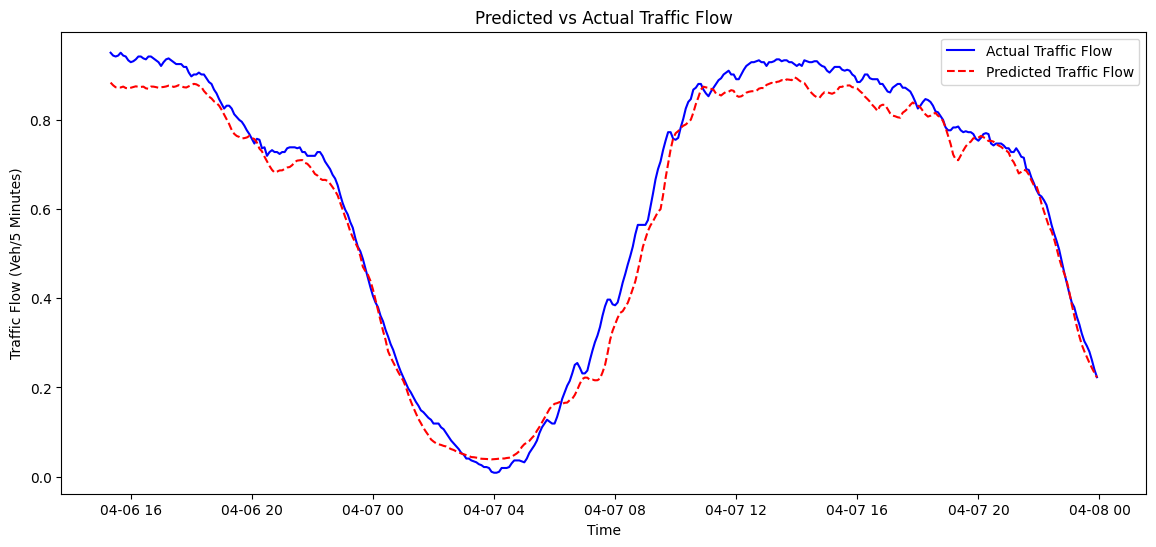

In [18]:
# timestamps from validation set.
timestamps = time_flow.index[-len(y_val):]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_val[:, -1], label='Actual Traffic Flow', color='blue')
plt.plot(timestamps, y_pred, label='Predicted Traffic Flow', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Traffic Flow (Veh/5 Minutes)')
plt.title('Predicted vs Actual Traffic Flow')
plt.legend()
plt.show()


In [21]:
from folium.plugins import HeatMapWithTime
import folium
import pandas as pd
import numpy as np
import branca.colormap as cm

# Sample time_flow DataFrame
# Ensure that your actual DataFrame has a timestamp index and valid flow data
time_flow = pd.DataFrame({
    "THIRD": time_flow['THIRD Flow (Veh/5 Minutes)'].tolist(),
    "INDIANA": time_flow['INDIANA Flow (Veh/5 Minutes)'].tolist(),
    "LORENA": time_flow['LORENA Flow (Veh/5 Minutes)'].tolist(),
    "MARRIETTA": time_flow['MARRIETTA Flow (Veh/5 Minutes)'].tolist(),
    "SOTO": time_flow['SOTO Flow (Veh/5 Minutes)'].tolist(),
    "SANTA_FE": time_flow['SANATA FE / MATEO Flow (Veh/5 Minutes)'].tolist(),
    "CENTRAL_AVE": time_flow['CENTRAL AVE Flow (Veh/5 Minutes)'].tolist(),
    "FM_110_NB": time_flow['FM 110 NB Flow (Veh/5 Minutes)'].tolist(),
    "HOOVER_1": time_flow['HOOVER 1 Flow (Veh/5 Minutes)'].tolist(),
    "VERMONT_2": time_flow['VERMONT 2 Flow (Veh/5 Minutes)'].tolist(),
    "VERMONT_1": time_flow['VERMONT 1 Flow (Veh/5 Minutes)'].tolist(),
    "BUDLONG": time_flow['BUDLONG Flow (Veh/5 Minutes)'].tolist(),
    "NORMANDIE_1": time_flow['NORMANDIE 1 Flow (Veh/5 Minutes)'].tolist()
}, index=pd.date_range("2024-04-01", periods=2016, freq="5T"))

detector_locations = {
    "THIRD": (34.032661, -118.182471),
    "INDIANA": (34.031713, -118.190515),
    "LORENA": (34.029648, -118.199219),
    "MARRIETTA": (34.029065, -118.211497),
    "SOTO": (34.029636, -118.217534),
    "SANATA_FE": (34.027652, -118.232238),
    "CENTRAL_AVE": (34.028251, -118.253349),
    "FM_100_NB": (34.038055, -118.279858),
    "HOOVER_1": (34.037067, -118.286318),
    "VERMONT_2": (34.03706, -118.289279),
    "VERMONT_1": (34.037096, -118.294389),
    "BUDLONG": (34.037129, -118.296691),
    "NORMANDIE_1": (34.037222, -118.302221)
}

# Normalize flow values
max_flow = time_flow.max().max()
time_flow = time_flow / max_flow  # Scale between 0-1

# Prepare Heatmap Data
heatmap_data = []
for timestamp, row in time_flow.iterrows():
    time_slot = []
    for column, flow_value in row.items():
        detector_id = column.split()[0]
        if detector_id in detector_locations:
            lat, lon = detector_locations[detector_id]
            time_slot.append([lat, lon, flow_value])
    heatmap_data.append(time_slot)

# Flatten the data
flattened_data = []
for timestamp, time_slot in zip(time_flow.index, heatmap_data):
    for lat, lon, weight in time_slot:
        flattened_data.append([timestamp, lat, lon, weight])

# Create DataFrame
df_heatmap = pd.DataFrame(flattened_data, columns=["Timestamp", "Latitude", "Longitude", "Weight"])

# Convert Timestamp to datetime and sort
df_heatmap['Timestamp'] = pd.to_datetime(df_heatmap['Timestamp'])
df_heatmap = df_heatmap.sort_values(by="Timestamp")

# Prepare data for HeatMapWithTime
time_index = list(df_heatmap['Timestamp'].astype(str).unique())

data = []
for _, d in df_heatmap.groupby('Timestamp'):
    data.append([[row['Latitude'], row['Longitude'], row['Weight']] for _, row in d.iterrows()])

hmt = folium.Map(location=[34.028251, -118.253349],
                tiles="cartodbpositron",
                zoom_start=13,
                control_scale=True,
                max_zoom=12,
                min_zoom=13
                 )

HeatMapWithTime(data,
                index=time_index,
                auto_play=True,
                max_opacity=0.8,
                radius=15,
                use_local_extrema=False
               ).add_to(hmt)

hmt


<ipython-input-21-d74051167fc6>:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  }, index=pd.date_range("2024-04-01", periods=2016, freq="5T"))
